## Import modules

In [1]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# model
from sklearn.svm import SVC

## Prepare graphics

In [2]:
def plot_roc(pipe, Xtest, ytest):
    yscores = pipe.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

## Load, clean and split the data

In [3]:
raw_data = pd.read_csv("Data/HR_Analytics.csv")

In [4]:
# Assign columns to column groups
catcols = ["AgeGroup", "SalarySlab", "Department", "EducationField", "JobRole", "MaritalStatus"]
numcols = ["Education", "EnvironmentSatisfaction", "BusinessTravel", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", 
           "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance", "OverTime", "Gender", "Age", "DailyRate", "DistanceFromHome", 
           "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
           "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
delcols = ["EmpID", "EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"]

# clean data
def clean_data(DF, delcols=delcols):
    df = DF.drop_duplicates()
    df = df.drop(delcols, axis=1)
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Female": 1,
                     "Male": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    #df = df.dropna(axis=0)
    return df

data = clean_data(raw_data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop("Attrition", axis=1), 
                                                data["Attrition"], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data["Attrition"], 
                                                random_state=42)

In [5]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 1212 to 852
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1178 non-null   int64  
 1   AgeGroup                  1178 non-null   object 
 2   BusinessTravel            1178 non-null   int64  
 3   DailyRate                 1178 non-null   int64  
 4   Department                1178 non-null   object 
 5   DistanceFromHome          1178 non-null   int64  
 6   Education                 1178 non-null   int64  
 7   EducationField            1178 non-null   object 
 8   EnvironmentSatisfaction   1178 non-null   int64  
 9   Gender                    1178 non-null   int64  
 10  HourlyRate                1178 non-null   int64  
 11  JobInvolvement            1178 non-null   int64  
 12  JobLevel                  1178 non-null   int64  
 13  JobRole                   1178 non-null   object 
 14  JobSat

## Prepare preprocessing

In [6]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy="median")
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([("imputer", simpimp),
                    ("scaler", std)])

coltrans = ColumnTransformer(transformers=[("encoder", encoder, catcols),
                                           ("numpipe", numpipe, numcols)])
selection = SelectPercentile(percentile=90) # percentile=10

## Initialize estimator

In [7]:
svc = SVC(C=1,
          kernel="poly",
          degree=3,
          gamma="auto",
          class_weight="balanced",
          cache_size=1000, 
          probability=True,
          random_state=42) 

## Set search space

In [8]:
search_space = {#"estimator__C": [0.1, 1, 10],
                #"estimator__kernel": ["poly", "rbf", "sigmoid"],
                #"estimator__degree": [2, 3], # only significant if kernel="poly"
                #"estimator__gamma": ["auto", "scale", 0.001, 0.1, 100],
                #"selector__percentile": [90]
                #"prepper__numpipe__imputer__strategy": ["mean", "median"]
               }

## Finish pipeline and run grid search

{}
Best F1 score: 51.39%
--------------------------------------------------------
F1 score on test set:	64.00%
Recall on test set:	68.09%
Precision on test set:	60.38%


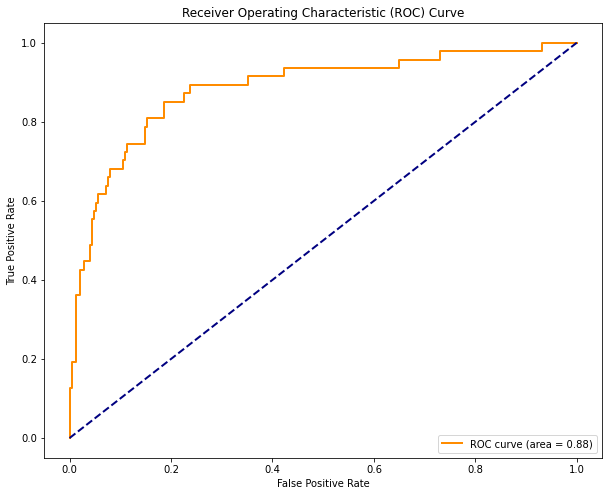

In [9]:
pipe_svc = Pipeline([("prepper", coltrans),
                     ("selector", selection),
                     ("estimator", svc)])

pipe_svc = GridSearchCV(estimator=pipe_svc,
                        param_grid=search_space,
                        scoring="f1",
                        cv=6,
                        n_jobs=-1)
pipe_svc.fit(Xtrain, ytrain)
#model_svc = pipe_svc.best_estimator_
#print(grid_svc.best_estimator_)
print(pipe_svc.best_params_)
print(f"Best F1 score: {pipe_svc.best_score_.mean():.2%}")
print("--------------------------------------------------------")
ypred = pipe_svc.predict(Xtest)
print(f"F1 score on test set:\t{f1_score(ytest, ypred):.2%}")
print(f"Recall on test set:\t{recall_score(ytest, ypred):.2%}")
print(f"Precision on test set:\t{precision_score(ytest, ypred):.2%}")
plot_roc(pipe_svc, Xtest, ytest)

In [10]:
results = pd.DataFrame(pipe_svc.cv_results_).sort_values(by="mean_test_score", ascending=False).head(8)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.275343,0.011095,0.013587,0.000331,{},0.553846,0.59375,0.392857,0.538462,0.459016,0.545455,0.513898,0.067372,1


# Result:
## The best SVC model we've found achieved an
## F1 score of 64.00% and a 
## ROC-AUC score of 88%
## on the test set.

[Text(0.5, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

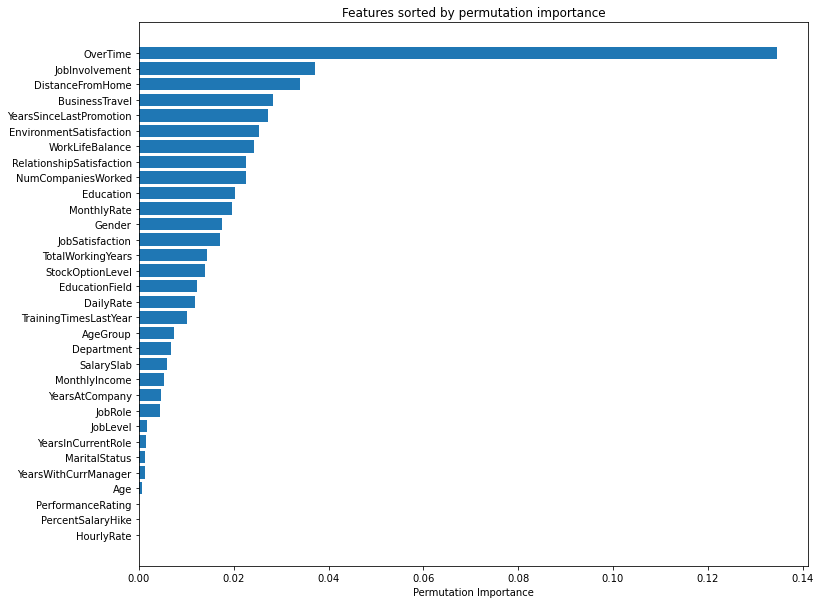

In [19]:
# Estimate feature importance through permutation importance
result = permutation_importance(pipe_svc, Xtrain, ytrain, n_repeats=50, random_state=42)
importance_scores = abs(result.importances_mean)
#pipe_rfc = pipe_rfc.fit(features_train, target_train)
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title="Features sorted by permutation importance",
      xlabel="Permutation Importance")

In [17]:
abs(result.importances_mean)

array([0.00987637, 0.0055627 , 0.02907491, 0.01433691, 0.00925709,
       0.03183329, 0.02444829, 0.01025945, 0.02215174, 0.02201733,
       0.        , 0.03502644, 0.00518172, 0.00562291, 0.01641185,
       0.00034112, 0.01542401, 0.0088854 , 0.0176579 , 0.01916816,
       0.13661487, 0.        , 0.        , 0.02462878, 0.01353102,
       0.01863054, 0.01244767, 0.01873858, 0.00042653, 0.00170832,
       0.02630684, 0.00303222])